## Step 3 - Predictive performance of your blackbox model and white-box model implementation

Content of this third step :
1. Analyze the predictive performance of our blackbox model 
2. Implement a whitebox model 
3. Compare the blackbox model with the performance of whitebox models

In [1]:
pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import statements
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from pygam import LogisticGAM, s,  f
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

### 1. Analyze the predictive performance of our blackbox model 

The chosen blackbox model is a catboost model, saved in this notebook. First, we load this catboost model.


In [3]:
# Load dataset
df = pd.read_csv('../Dataset/df_processed.csv')
X = df.drop('Grade', axis=1).copy()
y = df['Grade'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
# Load the model from the file
model_filename = '../Models/blackbox_model.pkl'
blackbox_model = joblib.load(model_filename)
y_pred_blackbox = blackbox_model.predict(X_test)
y_pred_blackbox_train = blackbox_model.predict(X_train)

Let's now analyse the performances of this model.

Evaluation metrics of the blackbox model :
Accuracy train score :  66.14 %
Precision train score :  77.08 %
Recall train score :  18.25 %
F1 train score :  29.509999999999998 %


Accuracy test score :  65.09 %
Precision test score :  77.75 %
Recall test score :  18.19 %
F1 test score :  29.49 %




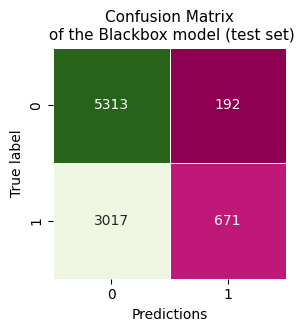

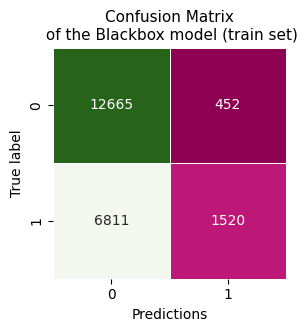

In [5]:
print("Evaluation metrics of the blackbox model :")

# Printing the evaluation metrics of this blackbox catboost model for test set 
accuracy_catboost_train = accuracy_score(y_train, y_pred_blackbox_train)
precision_catboost_train = precision_score(y_train, y_pred_blackbox_train)
recall_catboost_train = recall_score(y_train, y_pred_blackbox_train)
f1_catboost_train = f1_score(y_train, y_pred_blackbox_train)

print('Accuracy train score : ', np.round(accuracy_catboost_train, 4)*100, '%')
print('Precision train score : ', np.round(precision_catboost_train, 4)*100, '%')
print('Recall train score : ', np.round(recall_catboost_train, 4)*100, '%')
print('F1 train score : ', np.round(f1_catboost_train, 4)*100, '%')
print('\n')

# Printing the evaluation metrics of this blackbox catboost model for train set
accuracy_catboost_test = accuracy_score(y_test, y_pred_blackbox)
precision_catboost_test = precision_score(y_test, y_pred_blackbox)
recall_catboost_test = recall_score(y_test, y_pred_blackbox)
f1_catboost_test = f1_score(y_test, y_pred_blackbox)

print('Accuracy test score : ', np.round(accuracy_catboost_test, 4)*100, '%')
print('Precision test score : ', np.round(precision_catboost_test, 4)*100, '%')
print('Recall test score : ', np.round(recall_catboost_test, 4)*100, '%')
print('F1 test score : ', np.round(f1_catboost_test, 4)*100, '%')
print('\n')

# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_test, y_pred_blackbox)
sns.heatmap(cm, annot=True, fmt='d', cmap='PiYG', cbar=False, annot_kws={"size": 10}, cbar_kws={"shrink": 0.5}, linewidths=0.5, linecolor='white')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.title('Confusion Matrix\n of the Blackbox model (test set)', fontsize=11)
plt.show()

# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_train, y_pred_blackbox_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='PiYG', cbar=False, annot_kws={"size": 10}, cbar_kws={"shrink": 0.5}, linewidths=0.5, linecolor='white')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.title('Confusion Matrix\n of the Blackbox model (train set)', fontsize=11)
plt.show()


**Blackbox model performance summary**

For a threshold set at 0.5, its test accuracy remains fairly low, equal to 77.31%, meaning that around a third of individuals are misclassified. A closer look at the correlation matrix reveals that most of the test dataset's false predictions are due to false negatives (items predicted as 0 but whose true label is 1). Indeed, 19.18% of the test dataset are false negatives, for 3.5% false positives.

So the performance of our blackbox models is not optimal, but the positive point that demonstrates that the hyperparameter tuning has certainly been well done is that the model doesn't seem to be overfitting. Accuracy, recall, precision and F1 scores are more or less the same for the train and the test set, guaranteeing consistent performance from our dataset-independent model blackbox.

### 2. Implement Withebox models

In this step, we implement several model and keep the one having the best performances. For a model to be considered as a whitebox model, it needs two main characteristics : 
- The algorithm used is straightforward to understand, and we can clearly interpret how the input features are transformed into the output or target variable.
- We can identify the most important features to predict the target variable, and those features are understandable.

We mentionned in class 5 whitebox models easily interpretable. The one we can potentielly apply for our binary classification problem are the **Logistic Regression** (LR), **Decision Tree** (DT), **Generative Additive Models** (GAN), **Penalised Logistic Tree Regression** (PLTR). Let's implement several of them and keep the ones with the best performances to go further. Among the 5 white-box models studied in class, we implemented 3 of them to compare their performances : **Logistic Regression** (LR), **Decision Tree** (DT), **Generative Additive Models** (GAN).

In [6]:
# Apply a numerical mapping for categorical columns
categorical_mapping = {
    'Gender': {'female': 0, 'male': 1},
    'EthnicGroup': {'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4},
    'ParentEduc': {'some high school': 0, 'high school': 1, "associate's degree": 2, 'some college': 3, "bachelor's degree": 4, "master's degree": 5},
    'LunchType': {'standard': 0, 'free/reduced': 1},
    'ParentMaritalStatus': {'widowed': 0, 'divorced': 1, 'single': 2, 'married': 3},
    'PracticeSport': {'sometimes': 0, 'regularly': 1, 'never': 2},
    'WklyStudyHours': {'Less than 5 hours': 0, 'Between 5-10 hours': 1, 'More than 10 hours': 2}
}

columns_to_map = list(categorical_mapping.keys())
X_train_whitebox = X_train.copy()
X_test_whitebox = X_test.copy()
X_train_whitebox[columns_to_map] = X_train_whitebox[columns_to_map].replace(categorical_mapping)
X_test_whitebox[columns_to_map] = X_test_whitebox[columns_to_map].replace(categorical_mapping)

In [7]:
# Empty dataframe to store the results of our whitebox models
df_whitebox_results = pd.DataFrame(columns=['Model name', 'Model parameters', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

##### a. Whitebox model 1 : Logistic Regression

In [8]:
# 1 - Implement logistic Regression 
logreg = LogisticRegression()
logreg.fit(X_train_whitebox, y_train)
y_pred_logreg = logreg.predict_proba(X_test_whitebox)[:, 1]
y_pred_logreg = (y_pred_logreg > 0.5).astype(int)

# Compute evaluation metrics 
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

# Append the results to df_whitebox_results
results_dict_logistic = {
    'Model name': ['Logistic Regression'], 'Model parameters': [logreg.get_params()],
    'Accuracy': [accuracy_logreg], 'Precision': [precision_logreg], 'Recall': [recall_logreg], 'F1 Score': [f1_logreg]
    }
df_whitebox_results = pd.concat([df_whitebox_results, pd.DataFrame(results_dict_logistic)], ignore_index=True)

##### b. Whitebox model 2 : Decision Tree

In [9]:
# 2 - Implement Decision Tree - Without hyperparameters tuning
decision_tree1 = DecisionTreeClassifier()
decision_tree1.fit(X_train_whitebox, y_train)
y_pred_dt1 = decision_tree1.predict(X_test_whitebox)

# Calculate evaluation metrics for classification
accuracy_dt1 = accuracy_score(y_test, y_pred_dt1)
precision_dt1 = precision_score(y_test, y_pred_dt1)
recall_dt1 = recall_score(y_test, y_pred_dt1)
f1_dt1 = f1_score(y_test, y_pred_dt1)

# Append the results to df_whitebox_results
results_dict_dt = {
    'Model name': ['Decision Tree - without Tuning'], 'Model parameters': [decision_tree1.get_params()],
    'Accuracy': [accuracy_dt1], 'Precision': [precision_dt1], 'Recall': [recall_dt1], 'F1 Score': [f1_dt1]
    }
df_whitebox_results = pd.concat([df_whitebox_results, pd.DataFrame(results_dict_dt)], ignore_index=True)

In next step with apply a bayesian hyperparameters tuning to tune the parameters of the decision tree model.

In [10]:
# 2 bis - Implement Decision Tree - With hyperparameters tuning

# Objective function to minimize
def objective(params):
    decision_tree = DecisionTreeClassifier(
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        max_leaf_nodes=params['max_leaf_nodes'],
        min_samples_split=params['min_samples_split'],
        min_weight_fraction_leaf=params['min_weight_fraction_leaf'],
    )
    score = -cross_val_score(decision_tree, X_train_whitebox, y_train, cv=5, scoring='accuracy').mean()
    return score

# Space for hyperparameters gridsearch
space = {
    'max_depth': hp.randint('max_depth', 1, 13),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 11),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 21),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500, trials=trials, rstate=np.random.default_rng(seed=42))
print("Best Hyperparameters:", best)

best_max_depth = int(best['max_depth'])
best_min_samples_leaf = int(best['min_samples_leaf'])
best_max_leaf_nodes = int(best['max_leaf_nodes'])
best_min_samples_split = int(best['min_samples_split'])
best_min_weight_fraction_leaf = best['min_weight_fraction_leaf']

# Fit the model and make predictions
decision_tree2 = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    max_leaf_nodes=best_max_leaf_nodes,
    min_samples_split=best_min_samples_split,
    min_weight_fraction_leaf=best_min_weight_fraction_leaf,
)
decision_tree2.fit(X_train_whitebox, y_train)
y_pred_dt2 = decision_tree2.predict(X_test_whitebox)

# Calculate evaluation metrics for classification
accuracy_dt2 = accuracy_score(y_test, y_pred_dt2)
precision_dt2 = precision_score(y_test, y_pred_dt2)
recall_dt2 = recall_score(y_test, y_pred_dt2)
f1_dt2 = f1_score(y_test, y_pred_dt2)

# Append the results to df_whitebox_results
results_dict_dt2 = {
    'Model name': ['Decision Tree - with Tuning'], 'Model parameters': [decision_tree2.get_params()],
    'Accuracy': [accuracy_dt2], 'Precision': [precision_dt2], 'Recall': [recall_dt2], 'F1 Score': [f1_dt2]
    }
df_whitebox_results = pd.concat([df_whitebox_results, pd.DataFrame(results_dict_dt2)], ignore_index=True)

 13%|█▎        | 63/500 [00:04<00:30, 14.30trial/s, best loss: -0.6822086423718505]

##### Whitebox model 3 : Generative additive model (GAM)


GAN can be applied to **binary classification settings** as seen in the course (slide 39). The **additive logistic regression** will have the form : 
$$log(\frac{\mu(X)}{1-\mu(X)}) = \alpha + f_1(X_1) + … + f_p(X_p)$$

The $f_i(X_i)$ denote **smooth**, **non-parametrics** functions. It could refer to any distribution from exponential family, such as Gaussian, binomial, Poisson etc...

**Advantages on GAN models** : 
- It allows us to easily examine the **partial relationships** betwen the target variable and the features. Its additive nature ensures that the **marginal impact** of a single  variable **does not depend on the others** in the model.
- The **non-linear fits** can potentially make more accurate predictions of the target. 


**Remark :** For the Python implementation, we can use the packages pyGAM, PiML, and statsmodels. The **pyGAM library** comes with different non parametric functions that we can apply to our features : 
- We apply a **spline terms** 's' for continuous numeric features (NbSiblings column is actually the only one)
- And **factor terms** 'f' for categorical features (all the others)


In [ ]:
# Implement Generative Additive Model - Without hyperparameters tuning
n_splines = X_train_whitebox.shape[1] 
X_train_array = np.array(X_train_whitebox)
y_train_array = np.array(y_train)

# Number of siblings is the only continuous numerical variable, all others are categorical
loggam_1 = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + s(8) + f(9) + f(10), constraints = 'none').gridsearch(X_train_array, y_train_array)
predictions = loggam_1.predict(X_test_whitebox)
y_pred_loggam1 = predictions*1

# Calculate evaluation metrics for classification
accuracy_loggam_1 = accuracy_score(y_test, y_pred_loggam1)
precision_loggam_1 = precision_score(y_test, y_pred_loggam1)
recall_loggam_1 = recall_score(y_test, y_pred_loggam1)
f1_loggam_1 = f1_score(y_test, y_pred_loggam1)

# Append the results to df_whitebox_results
results_dict_loggam_1 = {
    'Model name': ['GAM - without Tuning'], 'Model parameters': [loggam_1.get_params()],
    'Accuracy': [accuracy_loggam_1], 'Precision': [precision_loggam_1], 'Recall': [recall_loggam_1], 'F1 Score': [f1_loggam_1]
    }
df_whitebox_results = pd.concat([df_whitebox_results, pd.DataFrame(results_dict_loggam_1)], ignore_index=True)

Lambda values are : 
- by default for spline terms $s()$, the penalty value on their 2nd derivative, which encourage the functions to be smoother
- by default for factor terms $f()$, a L2 penalty (ridge) which encourages to take on smaller weight values.

In [ ]:
# Implement Generative Additive Model - With hyperparameters tuning
n_splines = X_train_whitebox.shape[1] 
X_train_array = np.array(X_train_whitebox)
y_train_array = np.array(y_train)
n_features = X_train_whitebox.shape[1]

# Regularization parameters to tune
lams = np.random.rand(200, n_features)
lams = lams * 6 - 3 
lams = 10 ** lams 

# Number of siblings is the only continuous numerical variable, all others are categorical
loggam_2 = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + s(8) + f(9) + f(10), constraints = 'none').gridsearch(X_train_array, y_train_array, lam=lams)
predictions = loggam_2.predict(X_test_whitebox)
y_pred_loggam_2 = predictions*1

# Compute evaluation metrics
accuracy_loggam_2 = accuracy_score(y_test, y_pred_loggam_2)
precision_loggam_2 = precision_score(y_test, y_pred_loggam_2)
recall_loggam_2 = recall_score(y_test, y_pred_loggam_2)
f1_loggam_2 = f1_score(y_test, y_pred_loggam_2)

# Append the results to df_whitebox_results
results_dict_loggam_2 = {
    'Model name': ['GAM - with Tuning'], 'Model parameters': [loggam_2.get_params()],
    'Accuracy': [accuracy_loggam_2], 'Precision': [precision_loggam_2], 'Recall': [recall_loggam_2], 'F1 Score': [f1_loggam_2]
    }
df_whitebox_results = pd.concat([df_whitebox_results, pd.DataFrame(results_dict_loggam_2)], ignore_index=True)

In [ ]:
loggam_2.summary()

One last model only keeping the significant features.

In [ ]:
# Implement Generative Additive Model - With hyperparameters tuning
n_splines = X_train_whitebox.shape[1] 
X_train_reduced = X_train_whitebox.drop(columns=['ParentMaritalStatus', 'IsFirstChild', 'NrSiblings','School_Bus'])
X_test_reduced = X_test_whitebox.drop(columns=['ParentMaritalStatus', 'IsFirstChild', 'NrSiblings','School_Bus'])
X_train_array = np.array(X_train_reduced)
y_train_array = np.array(y_train)
n_features = X_train_whitebox.shape[1]

# Regularization parameters to tune
lams = np.random.rand(200, 7)
lams = lams * 6 - 3 
lams = 10 ** lams 

# Number of siblings is the only continuous numerical variable, all others are categorical
loggam_3 = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6), constraints = 'none').gridsearch(X_train_array, y_train_array, lam=lams)
predictions = loggam_3.predict(X_test_reduced)
y_pred_loggam_3 = predictions*1

# Compute evaluation metrics
accuracy_loggam_3 = accuracy_score(y_test, y_pred_loggam_3)
precision_loggam_3 = precision_score(y_test, y_pred_loggam_3)
recall_loggam_3 = recall_score(y_test, y_pred_loggam_3)
f1_loggam_3 = f1_score(y_test, y_pred_loggam_3)

# Append the results to df_whitebox_results
results_dict_loggam_3 = {
    'Model name': ['GAM - with features selection'], 'Model parameters': [loggam_3.get_params()],
    'Accuracy': [accuracy_loggam_3], 'Precision': [precision_loggam_3], 'Recall': [recall_loggam_3], 'F1 Score': [f1_loggam_3]
    }
df_whitebox_results = pd.concat([df_whitebox_results, pd.DataFrame(results_dict_loggam_3)], ignore_index=True)

### 3. Compare whitebox model performance with blackbox model 

In previous step, we implemented three whitebox models : **Logistic Regression** (LR), **Decision Tree** (DT), **Generative Additive Models** (GAN). Let's compare their results with our blackbox models results, and save the model having the best performances.

In [ ]:
# Append the Blackbox results to df_whitebox_results
results_dict_blackbox = {
    'Model name': ['Blackbox model'], 'Model parameters': [blackbox_model.get_params()],
    'Accuracy': [accuracy_catboost_test], 'Precision': [precision_catboost_test], 'Recall': [recall_catboost_test], 'F1 Score': [f1_catboost_test]
    }
df_whitebox_results = pd.concat([df_whitebox_results, pd.DataFrame(results_dict_blackbox)], ignore_index=True)
df_whitebox_results_to_print = df_whitebox_results.drop(columns=['Model parameters'], inplace=False).copy()
df_whitebox_results_to_print

In [ ]:
# Print all the confusion matrix
model_names = ['Logistic Regression', 'Decision Tree', 'Decision Tree tuned', 'Logistic GAM', 'Logistic GAM tuned', 'Blackbox model']
predictions = [y_pred_logreg, y_pred_dt1, y_pred_dt2, y_pred_loggam1, y_pred_loggam_2, y_pred_blackbox]

fig, axes = plt.subplots(1, 6, figsize=(24, 4.5))
for i in range(6):
    ax = axes[i]
    cm = confusion_matrix(y_test, predictions[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='PiYG', cbar=False, ax=ax,
                annot_kws={"size": 13}, cbar_kws={"shrink": 0.5}, linewidths=0.5, linecolor='white')
    ax.set_xlabel('Predictions', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_title(model_names[i], fontsize=15)

plt.tight_layout()
plt.show()

**Comparison of whitebox and blackbox models performance**

If we compare the performance of our whitebox models with that of the blackbox, we can see that we achieve an accuracy on the test set very close to that of the blackbox catboost model, particularly with the OLS, the tuned decision Tree and the GAM. Indeed, these three models all have an accuracy of around 77%, approaching the 78% accuracy of our blackbox catboost model. 

Predictive performance is therefore very close, but we'll choose to save the GAM model. This is because it is more robust to overfitting than the decision tree, whose performance can vary greatly depending on the training dataset, and it also captures non-linear relationships between features and the variable of interest, which logistic regression does not.

### 4. Saving the chosen whitebox model

Of the various models we evaluated, we chose to continue with the **GAM (with Tuning)** model, which showed the **highest accuracy score** of all the whitebox models we tested. We therefore save this model and move on to try and explain the results of our catboost model based on this GAM whitebox model.

In [ ]:
# Save the best performance whitebox model to a file
model_filename = '../Models/whitebox_model.pkl'
joblib.dump(loggam_2, model_filename)